<a href="https://colab.research.google.com/github/suryakovvada/mix-praportions/blob/main/copy_of_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install Libraries
!pip install numpy pandas scikit-learn matplotlib

In [3]:
# Cell 2: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size  # Number of neurons in output layer

        # Xavier initialization for better training stability
        self.weights_ih = np.random.randn(hidden_size, input_size) * np.sqrt(2 / input_size)
        self.bias_h = np.zeros(hidden_size)
        self.weights_ho = np.random.randn(output_size, hidden_size) * np.sqrt(2 / hidden_size)
        self.bias_o = np.zeros(output_size)

        # Hyperparameters
        self.alpha = 1
        self.learning_rate = 0.02
        self.training_errors = []

    def forward(self, inputs):
        """Forward pass"""
        hidden_input = np.dot(self.weights_ih, inputs) + self.bias_h
        hidden_output = self.sigmoid(hidden_input)

        # Now the output layer has multiple neurons (4 for mix proportions)
        output_layer_output = np.dot(self.weights_ho, hidden_output) + self.bias_o
        return hidden_output, output_layer_output

    def backward(self, inputs, desired_output, hidden_output, output_layer_output):
        """Backward pass with gradient descent"""
        output_error = desired_output - output_layer_output

        # Backpropagation through hidden layer
        hidden_error = np.dot(self.weights_ho.T, output_error) * (hidden_output * (1 - hidden_output))

        # Compute gradients
        dw_output = self.learning_rate * np.outer(output_error, hidden_output)
        db_output = self.learning_rate * output_error
        dw_hidden = self.learning_rate * np.outer(hidden_error, inputs)
        db_hidden = self.learning_rate * hidden_error

        # Update weights and biases
        self.weights_ho += dw_output
        self.bias_o += db_output
        self.weights_ih += dw_hidden
        self.bias_h += db_hidden

    def train(self, training_data, desired_outputs, epochs=10000):
        """Train the ANN model"""
        num_samples = training_data.shape[0]

        for epoch in range(epochs):
            total_error = 0

            for i in range(num_samples):
                inputs = training_data[i]
                desired_output = desired_outputs[i]

                hidden_output, output_layer_output = self.forward(inputs)
                self.backward(inputs, desired_output, hidden_output, output_layer_output)

                total_error += np.mean((desired_output - output_layer_output) ** 2)

            avg_error = total_error / num_samples
            self.training_errors.append(avg_error)

            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, MSE: {avg_error:.6f}")

    def predict(self, inputs):
        """Predict mix proportions for given input strength"""
        predictions = []
        for input_sample in inputs:
            _, output_layer_output = self.forward(input_sample)
            predictions.append(output_layer_output)
        return np.array(predictions)


In [ ]:
# Cell 4: Plotting Functions
def plot_loss_curve(training_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(training_errors)
    plt.title('Training Loss Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    plt.show()

def plot_actual_vs_predicted(y_actual, y_predicted, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_predicted)
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], 'k--', lw=2)  # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_residuals(y_actual, y_predicted, title):
    residuals = (y_actual - y_predicted)/y_actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_predicted, residuals)
    plt.axhline(y=0, color='k', linestyle='--', lw=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals (Actual - Predicted)/actual')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [4]:
# Cell 5: Data Loading and Preprocessing
from google.colab import files
import io

# Upload the Excel file
uploaded = files.upload()
excel_file = next(iter(uploaded))

df = pd.read_excel(excel_file)

X_columns = ['W/C RATIO ', 'MIX PRAPOTIONS((C : FA : sand : CA))', 'CEMENT CONTENT©(kg/m^3)', 'FLY ASH CONTENT(FA)kg/m^3']

# Check if all columns exist before proceeding
for col in X_columns:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in the Excel file. Please check the spelling and case.")

X = df[X_columns].copy()
y = df['28D(mpa)'].values

def extract_proportions(mix_str):
    try:
        parts = mix_str.split(':')
        return list(map(float, parts))
    except:
        return [np.nan, np.nan, np.nan, np.nan]  # Return 4 NaNs

proportions = X['MIX PRAPOTIONS((C : FA : sand : CA))'].apply(extract_proportions)
X[['Cement_Prop', 'FA_Prop', 'Sand_Prop', 'CA_Prop']] = pd.DataFrame(proportions.tolist(), index=X.index)
X.drop('MIX PRAPOTIONS((C : FA : sand : CA))', axis=1, inplace=True)
X.fillna(X.mean(), inplace=True)

X = X.values
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

input_scaler = MinMaxScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

output_scaler = MinMaxScaler()
y_train_scaled = output_scaler.fit_transform(y_train)
y_test_scaled = output_scaler.transform(y_test)

Saving FINAL PROJECT EXCEL.xlsx to FINAL PROJECT EXCEL.xlsx


In [9]:
# Define input, hidden, and output sizes
input_size = 1  # Compressive strength is the input
hidden_size = 4  # Number of neurons in the hidden layer
output_size = y_train_scaled.shape[1]  # Output: Mix proportions (Cement, Fly Ash, Sand, Coarse Aggregate)

# Initialize the neural network
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Train the neural network on scaled data
nn.train(X_train_scaled, y_train_scaled, epochs=10000)


ValueError: shapes (4,1) and (7,) not aligned: 1 (dim 1) != 7 (dim 0)

In [ ]:
# Cell 7: Model Evaluation
y_train_pred_scaled = nn.predict(X_train_scaled)
y_test_pred_scaled = nn.predict(X_test_scaled)

y_train_pred = output_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_test_pred = output_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1))

# Calculate Performance Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("--- Training Performance ---")
print(f"Train Mean Squared Error: {train_mse:.2f}")
print(f"Train Root Mean Squared Error: {train_rmse:.2f}")
print(f"Train R-squared: {train_r2:.4f}")

print("\n--- Testing Performance ---")
print(f"Test Mean Squared Error: {test_mse:.2f}")
print(f"Test Root Mean Squared Error: {test_rmse:.2f}")
print(f"Test R-squared: {test_r2:.4f}")

--- Training Performance ---
Train Mean Squared Error: 2.28
Train Root Mean Squared Error: 1.51
Train R-squared: 0.9133

--- Testing Performance ---
Test Mean Squared Error: 1.96
Test Root Mean Squared Error: 1.40
Test R-squared: 0.9044


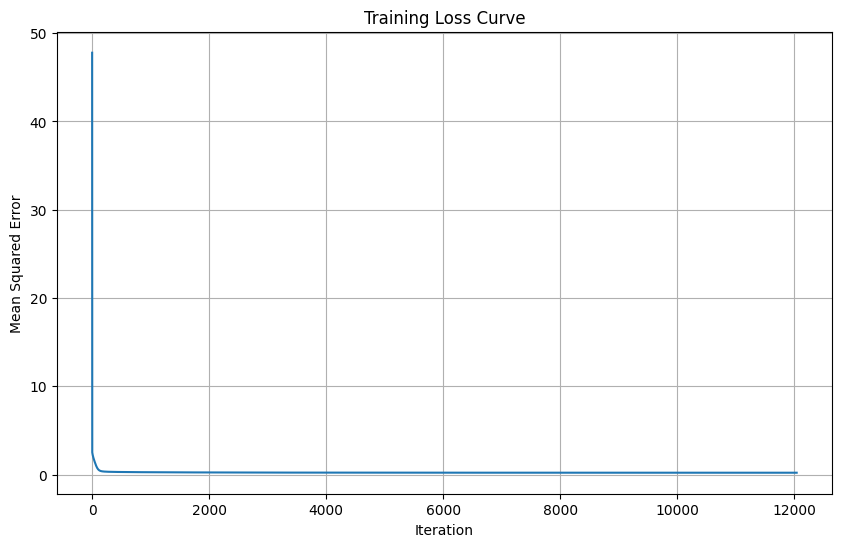

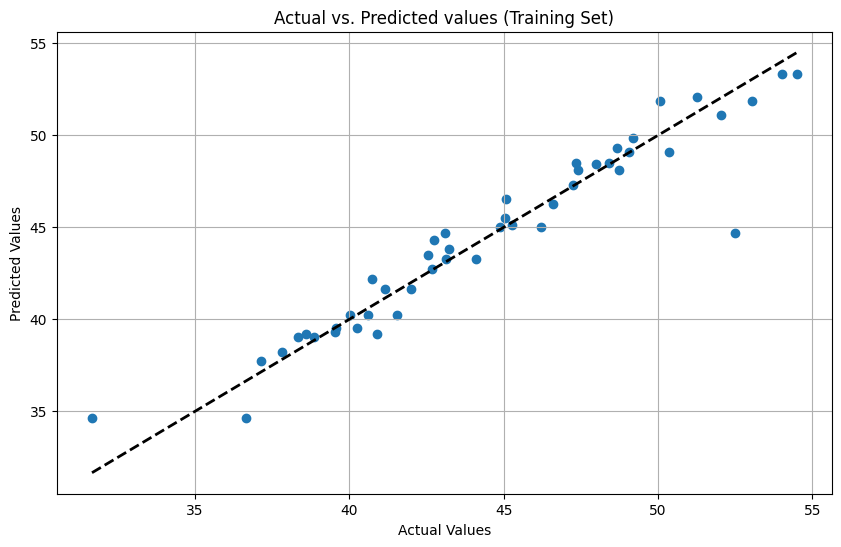

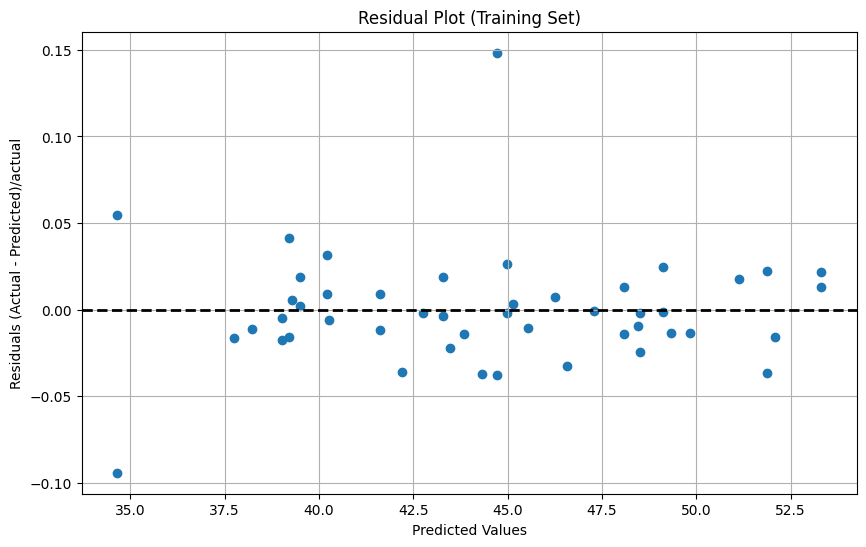

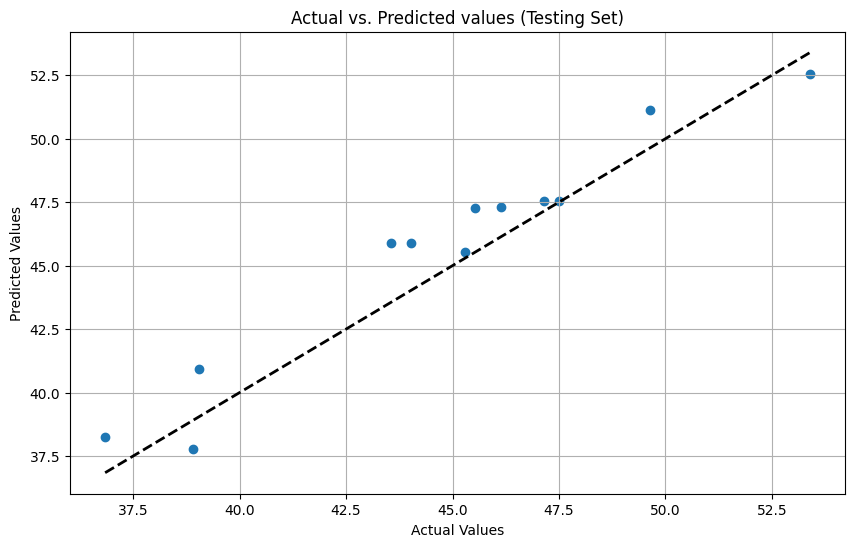

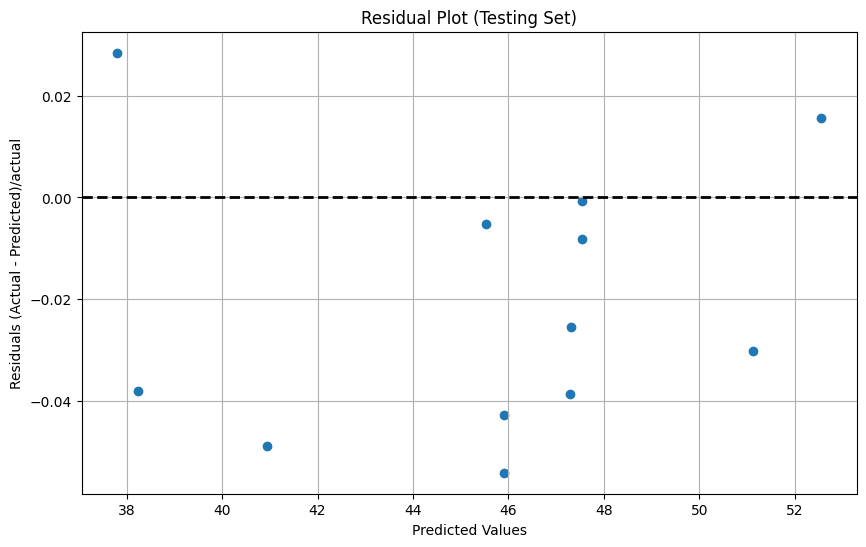

In [ ]:
# Cell 8: Plotting Results
plot_loss_curve(nn.training_errors)
plot_actual_vs_predicted(y_train, y_train_pred, 'Actual vs. Predicted values (Training Set)')
plot_residuals(y_train, y_train_pred, 'Residual Plot (Training Set)')
plot_actual_vs_predicted(y_test, y_test_pred, 'Actual vs. Predicted values (Testing Set)')
plot_residuals(y_test, y_test_pred, 'Residual Plot (Testing Set)')

In [ ]:
# Cell 9: Prediction on New Data
new_data = np.array([[0.48, 400, 0, 1.15, 1.30, 2.70, 3.05]])
new_data_df = pd.DataFrame(new_data, columns=['W/C RATIO ', 'CEMENT CONTENT©(kg/m^3)', 'FLY ASH CONTENT(FA)kg/m^3', 'Cement_Prop', 'FA_Prop', 'Sand_Prop', 'CA_Prop'])
new_data_scaled = input_scaler.transform(new_data_df)
predicted_strength_scaled = nn.predict(new_data_scaled)
predicted_strength = output_scaler.inverse_transform(predicted_strength_scaled.reshape(-1, 1))
print("\nPredicted compressive strength for new data:", predicted_strength[0][0])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np

# Step 1: Upload the Excel file
uploaded = files.upload()
excel_file = next(iter(uploaded))

# Step 2: Load the Excel file
data = pd.read_excel(excel_file)

# Step 3: Define the columns for actual and predicted values
actual_column = 'Actual'  # Replace with the correct column name from your data
predicted_column = 'Predicted'  # Replace with the correct column name from your data

# Ensure the columns exist
if actual_column not in data.columns or predicted_column not in data.columns:
    raise ValueError(f"Ensure the Excel file has columns '{actual_column}' and '{predicted_column}'.")

# Step 4: Extract actual and predicted values
actual_values = data[actual_column].values
predicted_values = data[predicted_column].values

# Step 5: Calculate the errors
errors = (actual_values - predicted_values)/actual_values  # Difference between actual and predicted
absolute_errors = abs(errors)  # Absolute errors
squared_errors = errors ** 2  # Squared errors

# Add a new column for errors in the DataFrame (optional)
data['Errors'] = errors
data['Absolute Errors'] = absolute_errors
data['Squared Errors'] = squared_errors

# Display the first few rows of the updated DataFrame with errors
print("Data with Errors:")
print(data.head())

# Step 6: Create the scatter plot with error bars
plt.figure(figsize=(5, 5))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.7, label='Data Points')

# Add error bars to show the respective errors
plt.errorbar(
    actual_values, predicted_values,
    yerr=absolute_errors,  # Use the absolute errors for the error bars
    fmt='o', color='blue', ecolor='orange', elinewidth=1.5, alpha=0.6, label='Error Bars'
)

# Plot the ideal fit line
min_value = min(min(actual_values), min(predicted_values))
max_value = max(max(actual_values), max(predicted_values))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Ideal Fit')

# Set plot labels and title
plt.title('Actual vs Predicted Values with Error Bars')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the scatter plot
plt.show()

# Step 7: Calculate error metrics
mae = absolute_errors.mean()
mse = squared_errors.mean()
rmse = np.sqrt(mse)

# Display the summary statistics for errors
print("\nSummary of Errors:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


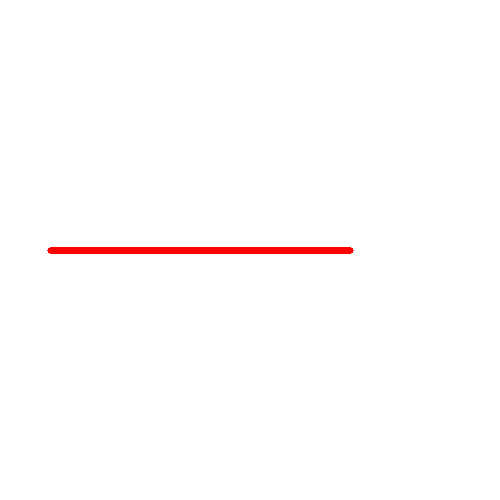

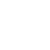

In [17]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Import the cv2_imshow function


# Define image size
width, height = 500, 500
image = np.ones((height, width, 3), dtype=np.uint8) * 255  # Create a white canvas

# Line properties
start_point = (50, 250)  # Starting coordinate (x, y)
length = 300             # Length of the line
thickness = 5            # Thickness of the line
color = (0, 0, 255)      # Red color in BGR format

# Compute end point based on length
end_point = (start_point[0] + length, start_point[1])

# Draw the line
cv2.line(image, start_point, end_point, color, thickness)

# Display the image using cv2_imshow instead of cv2.imshow
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Import the cv2_imshow function


# Define image size
width, height = 500, 500
image = np.ones((height, width, 3), dtype=np.uint8) * 255  # Create a white canvas

# Line properties
start_point = (50, 250)  # Starting coordinate (x, y)
length = 300             # Length of the line
thickness = 5            # Thickness of the line
color = (0, 0, 255)      # Red color in BGR format

# Compute end point based on length
end_point = (start_point[0] + length, start_point[1])

# Draw the line
cv2.line(image, start_point, end_point, color, thickness)

# Display the image using cv2_imshow instead of cv2.imshow
cv2_imshow(image)
# cv2.waitKey(0) #This line is not needed in Colab environment
# cv2.destroyAllWindows() #This line is not needed in Colab environment
# Define image size
width, height = 50, 50
image = np.ones((height, width, 3), dtype=np.uint8) * 255  # Create a white canvas

# Line properties
start_point = (50, 150)  # Starting coordinate (x, y)
length = 30             # Length of the line
thickness = 5            # Thickness of the line
color = (0, 0, 255)      # Red color in BGR format

# Compute end point based on length
end_point = (start_point[0] + length, start_point[1])

# Draw the line
cv2.line(image, start_point, end_point, color, thickness)

# Display the image using cv2_imshow instead of cv2.imshow
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()